In [11]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import os

In [12]:
preds = pd.read_csv("results/result.csv")
X = pd.read_csv("data/X_test.csv")

X["prediction"] = preds["prediction"]

In [13]:
rows = []
for cls in sorted(X["prediction"].unique()):
    counter = Counter()
    reviews = X.loc[X["prediction"] == cls, "review"].dropna()
    for review in reviews:
        notes = [note.strip().lower() for note in review.split(",")]
        counter.update(notes)
    for note, cnt in counter.most_common(5):
        rows.append({"class": cls, "note": note, "count": cnt})

top_notes_df = pd.DataFrame(rows)

## Find and plot the top 5 most frequent notes from the Review column

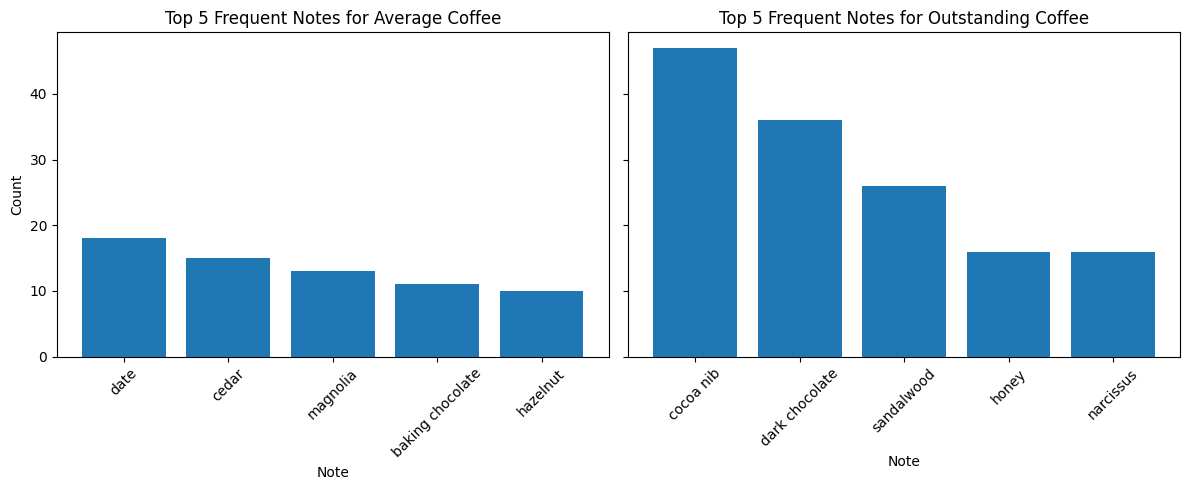

In [14]:
classes = sorted(top_notes_df["class"].unique())
fig, axes = plt.subplots(1, len(classes), figsize=(12, 5), sharey=True)

for ax, cls in zip(axes, classes):
    dfc = top_notes_df[top_notes_df["class"] == cls]
    ax.bar(dfc["note"], dfc["count"])
    ax.set_title(f"Top 5 Frequent Notes for {"Outstanding" if cls == 1 else "Average"} Coffee")
    ax.set_xlabel("Note")
    if ax is axes[0]:
        ax.set_ylabel("Count")
    ax.tick_params(axis="x", rotation=45)

os.makedirs('insight_plots', exist_ok=True)
plt.savefig('insight_plots/review.png', bbox_inches='tight', dpi=300)

plt.tight_layout()
plt.show()

## Find number of classes from each country

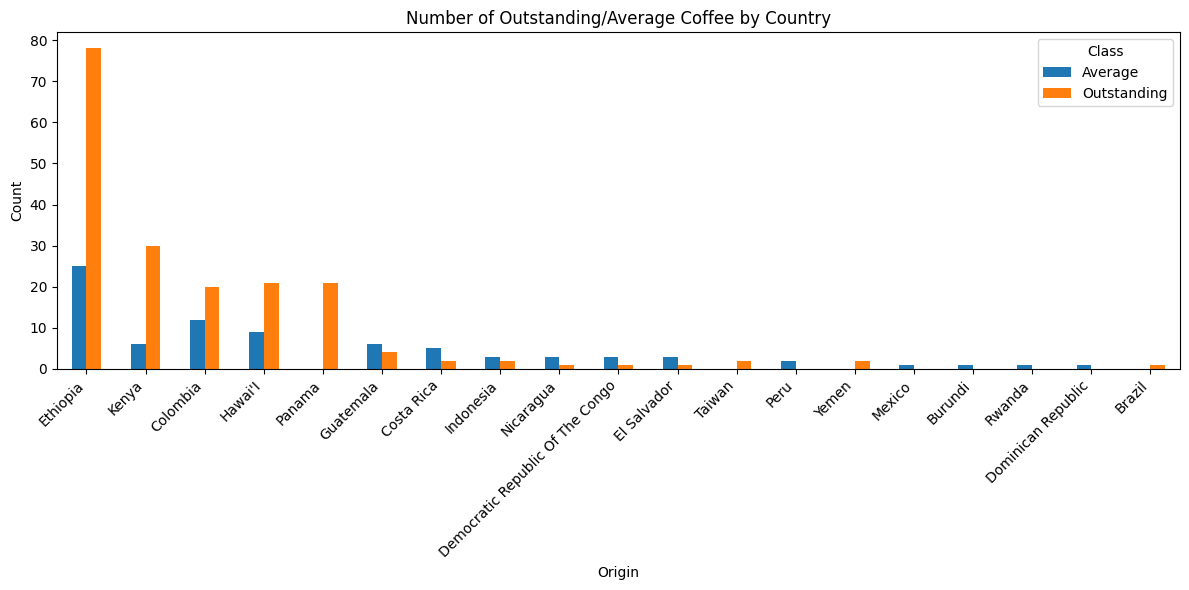

In [15]:
counts = X.groupby(["origin", "prediction"]).size().unstack(fill_value=0)

counts = counts.rename(columns={0: "Average", 1: "Outstanding"})

counts["total"] = counts.sum(axis=1)
counts = counts.sort_values(by="total", ascending=False)

counts.drop(columns="total").plot(
    kind="bar",
    figsize=(12, 6)
)

plt.xlabel("Origin")
plt.ylabel("Count")
plt.title("Number of Outstanding/Average Coffee by Country")
plt.legend(title="Class", loc="upper right")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

plt.savefig('insight_plots/country.png', bbox_inches='tight', dpi=300)

plt.show()

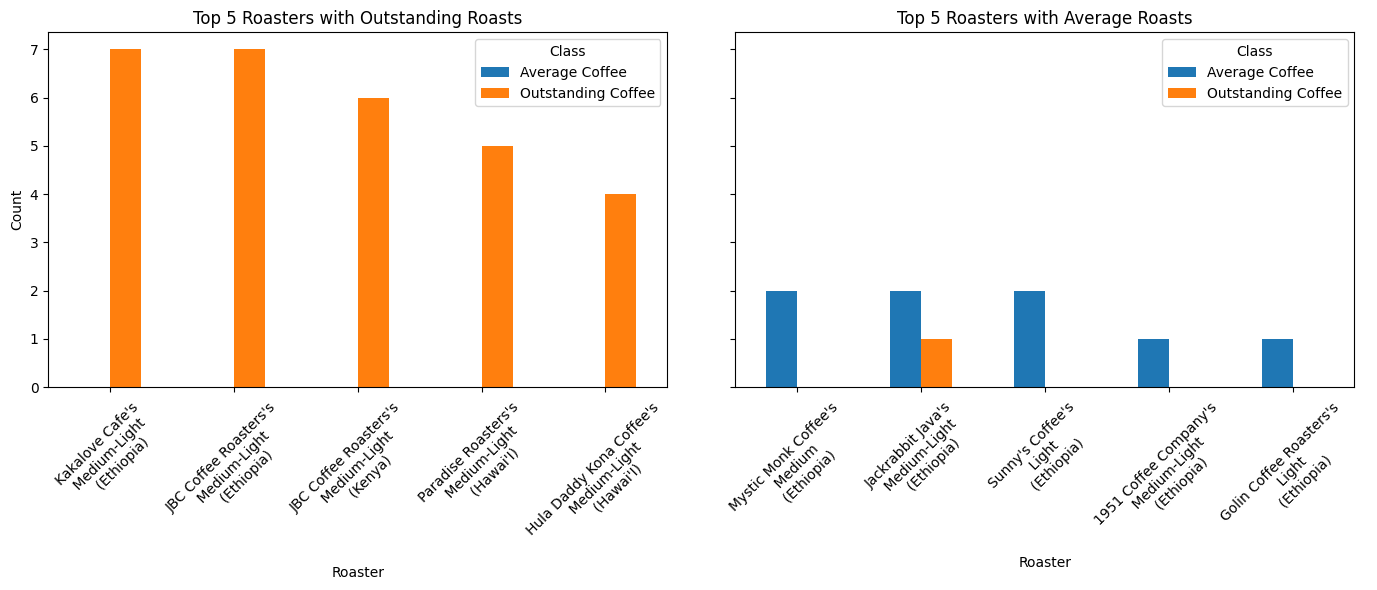

In [16]:
# 1. Build the custom label: "[Roaster Name]"s [Roast Type] ([Country])"
X["roaster_label"] = X.apply(
    lambda r: f"{r["roaster"]}'s \n {r["roast"]} \n ({r["origin"]})",
    axis=1
)

# 2. Compute counts per (roaster_label, prediction)
counts = X.groupby(['roaster_label', 'prediction']).size().unstack(fill_value=0)

# 3. Select top 5 by class-1 and top 5 by class-0
top1 = counts.sort_values(by=1, ascending=False).head(5)
top0 = counts.sort_values(by=0, ascending=False).head(5)

top1 = top1.rename(columns={0: 'Average Coffee', 1: 'Outstanding Coffee'})
top0 = top0.rename(columns={0: 'Average Coffee', 1: 'Outstanding Coffee'})


# 4. Plot side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Left: top 5 by class 1
top1.plot(kind='bar', ax=axes[0])
axes[0].set_title('Top 5 Roasters with Outstanding Roasts')
axes[0].set_xlabel('Roaster')
axes[0].set_ylabel('Count')
axes[0].legend(title='Class', loc='upper right')
axes[0].tick_params(axis='x', rotation=45)

# Right: top 5 by class 0
top0.plot(kind='bar', ax=axes[1])
axes[1].set_title('Top 5 Roasters with Average Roasts')
axes[1].set_xlabel('Roaster')
axes[1].legend(title='Class', loc='upper right')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()

plt.savefig('insight_plots/roasters.png', bbox_inches='tight', dpi=300)

plt.show()

/var/folders/69/phr3g_6x3cs1xhg4l6g391vm0000gn/T/ipykernel_8484/2340558705.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts  = X.groupby(['price_range','prediction']).size().unstack(fill_value=0)


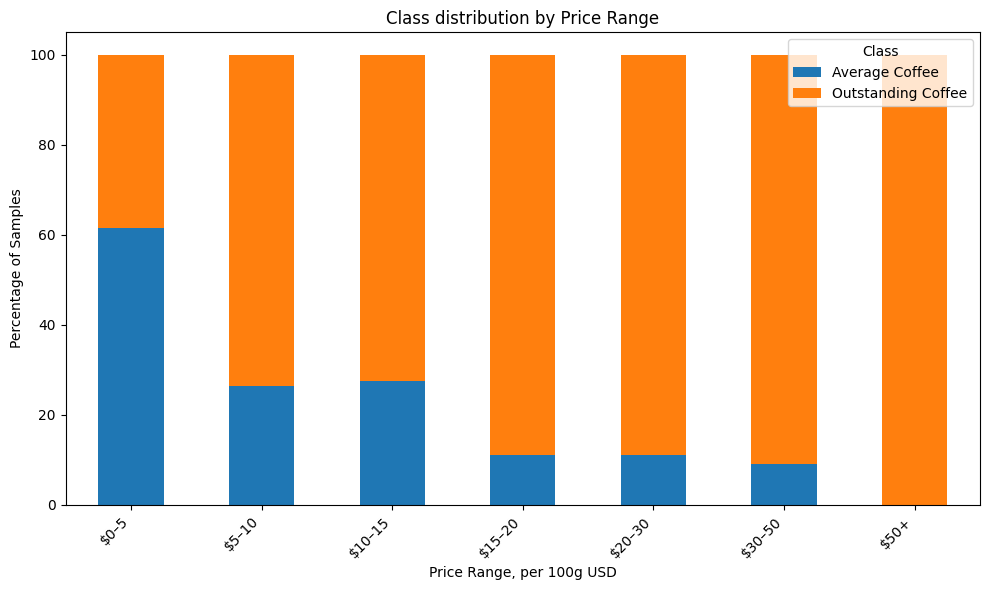

In [17]:
# 1. Define your bins & labels
bins  = [0, 5, 10, 15, 20, 30, 50, 100]
labels = ['$0–5','$5–10','$10–15','$15–20','$20–30','$30–50','$50+']

# 2. Bucket prices
X['price_range'] = pd.cut(X['100g_USD'], bins=bins, labels=labels, right=False)

# 3. Count and convert to percentages
counts  = X.groupby(['price_range','prediction']).size().unstack(fill_value=0)
percent = counts.div(counts.sum(axis=1), axis=0) * 100

percent = percent.rename(columns={0: 'Average Coffee', 1: 'Outstanding Coffee'})

# 4. Plot the distribution (stacked percentages)
ax = percent.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6)
)
ax.set_title('Class distribution by Price Range')
ax.set_xlabel('Price Range, per 100g USD')
ax.set_ylabel('Percentage of Samples')
ax.legend(title='Class', loc='upper right')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.savefig('insight_plots/price.png', bbox_inches='tight', dpi=300)

plt.show()